# Машинное обучение 1, ПМИ ФКН ВШЭ

## Семинар 9

## Градиентный бустинг

Сравним, как ведут себя бустинг и бэггинг с ростом числа базовых алгоритмов.

В случае бэггинга все базовые алгоритмы настраиваются на различные выборки из одного и того же распределения на $\mathbb{X} \times \mathbb{Y}$. При этом некоторые из них могут оказаться переобученными, однако усреднение позволяет ослабить этот эффект (объясняется тем, что для некоррелированных алгоритмов разброс композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов, т.е. много деревьев с меньшей вероятностью настроятся на некоторый нетипичный объект по сравнению с одним деревом). Если $N$ достаточно велико, то последующие добавления новых алгоритмов уже не позволят улучшить качество модели.

В случае же бустинга каждый алгоритм настраивается на ошибки всех предыдущих, это позволяет на каждом шаге настраиваться на исходное распределение все точнее и точнее. Однако при достаточно большом $N$ это является источником переобучения, поскольку последующие добавления новых алгоритмов будут продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, при этом уменьшая обобщающую способность итоговой композиции.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

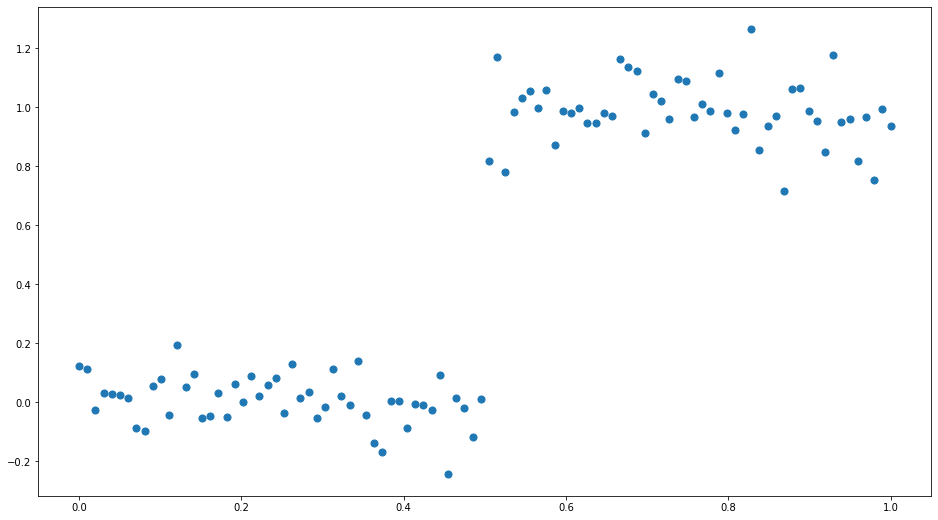

In [2]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

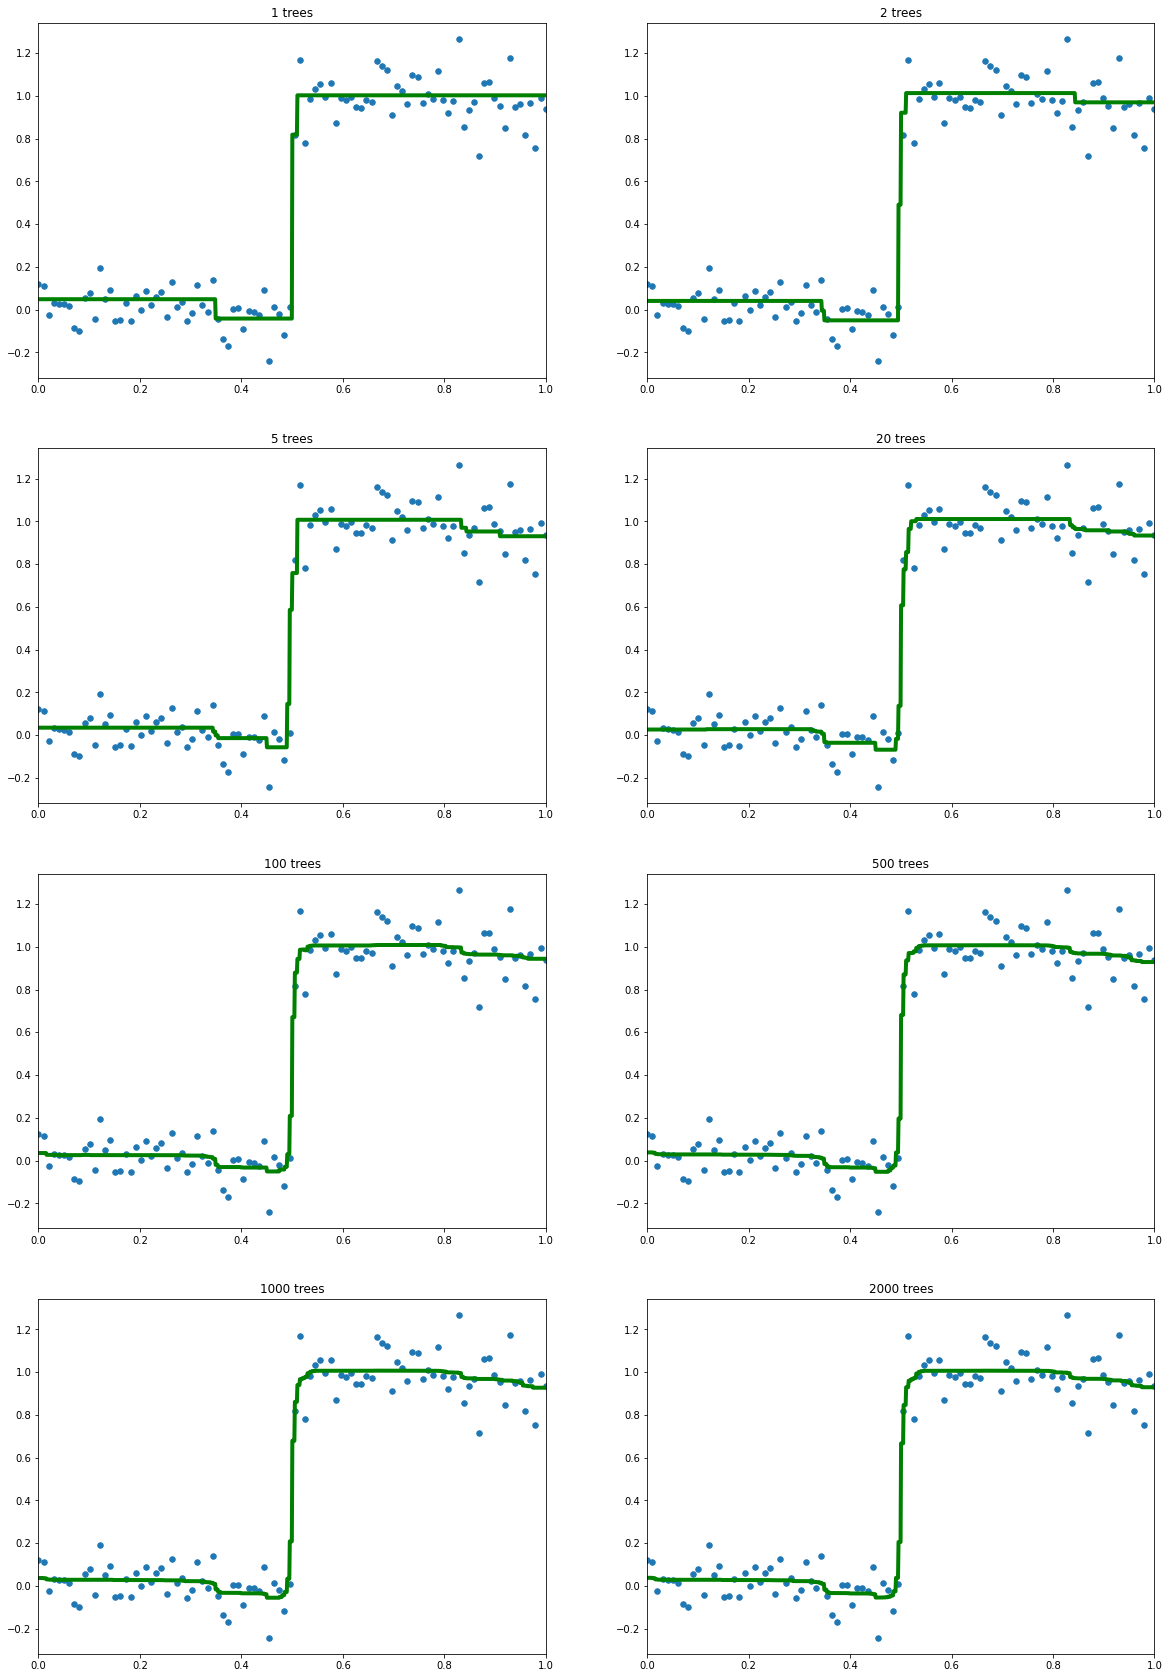

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для градинентного бустинга.

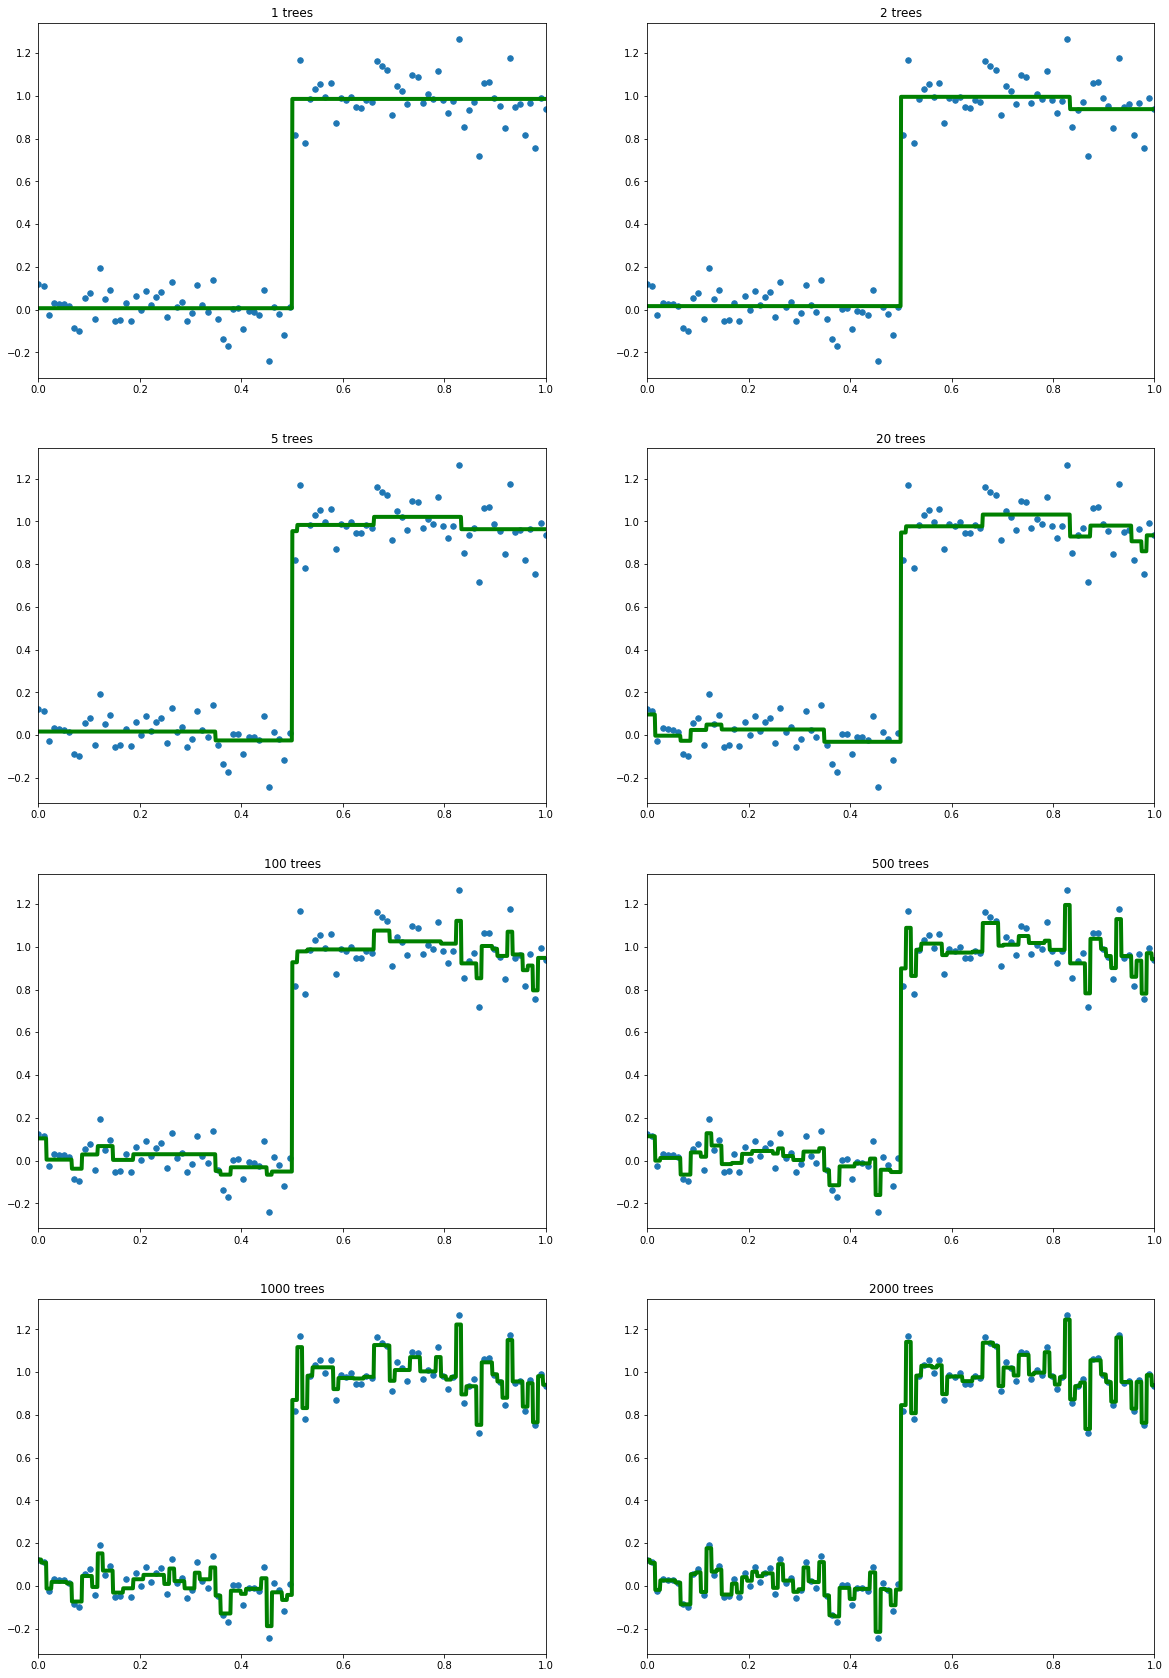

In [4]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.


Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или
же искусственным снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

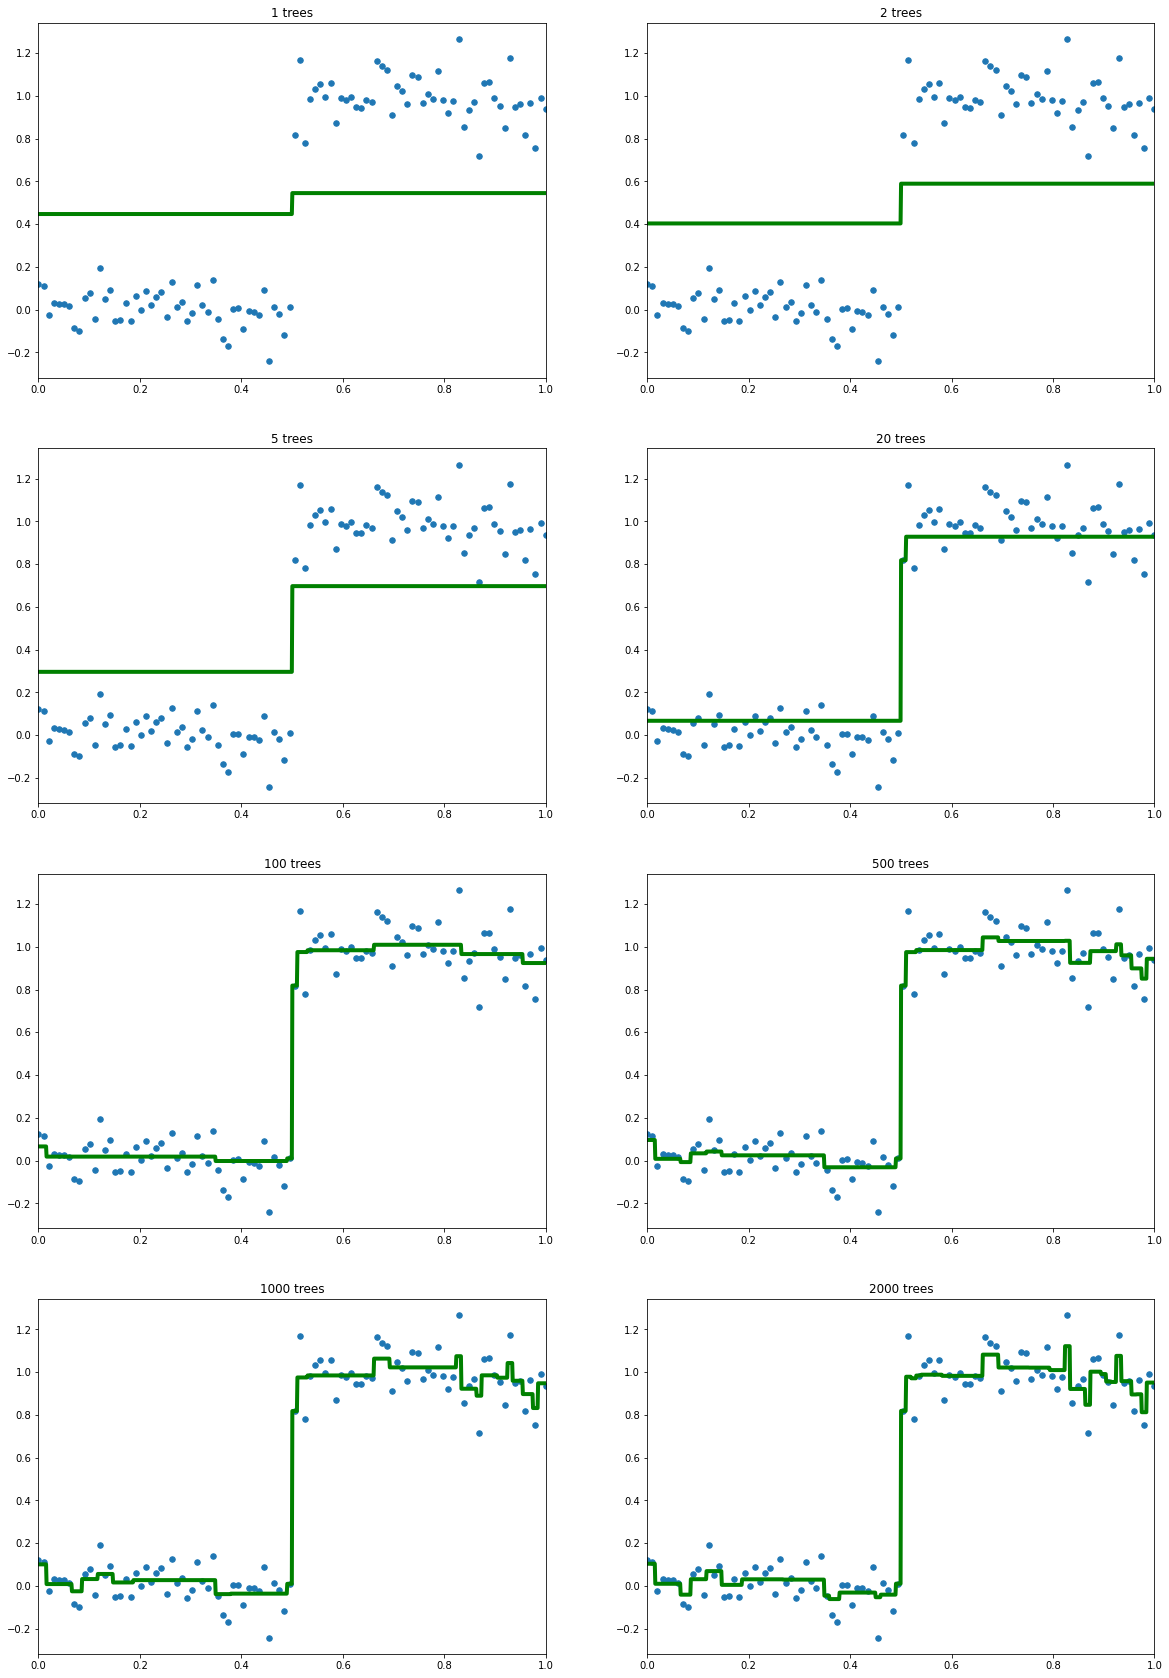

In [5]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Теперь проверим описанный выше эффект на реальных данных.

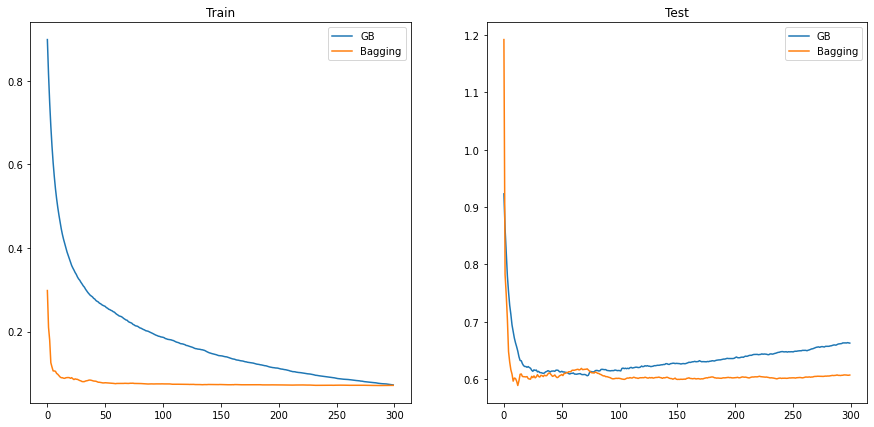

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

MAX_ESTIMATORS = 300

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))
    
gbclf = GradientBoostingRegressor(warm_start=True, max_depth=2, learning_rate=0.1)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))
    
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')
plt.gcf().set_size_inches(15,7)

## Градиентный бустинг и случайные леса

Сравним поведение двух методов построения композиции алгоритмов над деревьями на примере задачи [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse):

In [7]:
!wget  -O 'train_sem09.csv' -q 'https://www.dropbox.com/s/uha70sej5ugcrur/_train_sem09.csv?dl=1'

In [8]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

data = pd.read_csv('train_sem09.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [9]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613            8.67s
         2           1.1715            8.41s
         3           1.1009            8.30s
         4           1.0529            8.23s
         5           1.0130            8.15s
         6           0.9740            8.14s
         7           0.9475            8.58s
         8           0.9197            8.58s
         9           0.8979            8.64s
        10           0.8730            8.61s
        20           0.7207            8.22s
        30           0.6055            7.70s
        40           0.5244            7.31s
        50           0.4501            6.97s
        60           0.3908            6.59s
        70           0.3372            6.22s
        80           0.3009            5.86s
        90           0.2603            5.52s
       100           0.2327            5.17s
       200           0.0835            1.71s
CPU times: user 8.31 s, sys: 83.9 ms, total: 8.4 s
Wal

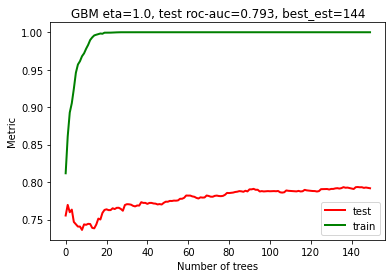

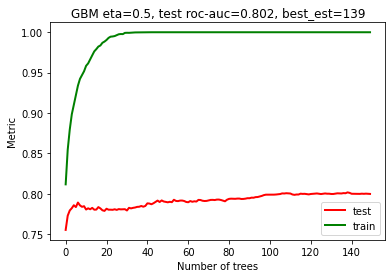

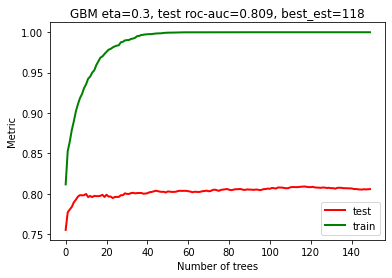

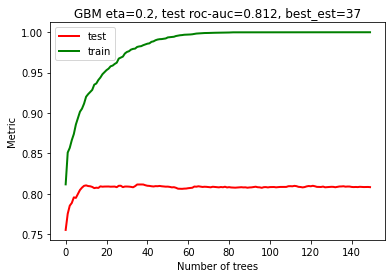

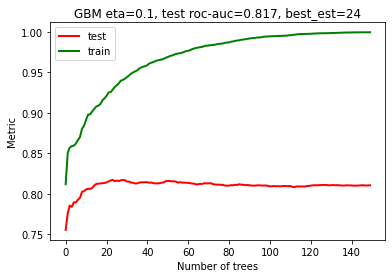

In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score

for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    l = roc_auc_score

    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('GBM eta=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Итого, лучшая композиция построена при $\eta = 0.1$, включает 24 базовых алгоритма и достигает значения 0.816 на контрольной выборке. При этом случайный лес с таким же количеством базовых алгоритмов уступает градиентному бустингу:

In [11]:
rf = RandomForestClassifier(n_estimators=24, random_state=0).fit(X_train, y_train)
print ('Train RF ROC-AUC =', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print ('Test RF ROC-AUC = ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Train RF ROC-AUC = 0.9999786482947104
Test RF ROC-AUC =  0.8037501166053144


Заметим также, что при всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, требующие вычислительных мощностей для их обучения.

Для достижения такого же качества случайному лесу требуется гораздо большее число базовых алгоритмов:

In [12]:
for n_estimators in range(10, 101, 10):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train)
    print (n_estimators, 'trees: train ROC-AUC =',  roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]), 'test ROC-AUC =',  roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

10 trees: train ROC-AUC = 0.9992847178728007 test ROC-AUC = 0.7783393519614807
20 trees: train ROC-AUC = 0.9999928827649035 test ROC-AUC = 0.7988291480995128
30 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8101178879727896
40 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8147832217510171
50 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8170063469169554
60 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8164414838654123
70 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8218340311712914
80 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8207034081042488
90 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8225527235413572
100 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8205767119454072


Напоследок можно посмотреть [визуализацию](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) градиентного бустинга для решающих деревьев различной глубины для функций различного вида.